In [1]:
# Load the dataset...
import torch
from pathlib import Path
from torch import nn
import sys
import numpy as np
from sklearn.datasets import fetch_openml
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from torch import optim
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

%matplotlib notebook

if("dataset" not in globals()):
    root_dir = Path().resolve()
    dataset = torchvision.datasets.MNIST(root_dir, download=True, transform=transforms.ToTensor())
    train, test = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.8), int(len(dataset) * 0.2)])

33.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

79.8%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


Extracting /home/isaac/Code/DeepLearning/Week_9_Dropout/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/isaac/Code/DeepLearning/Week_9_Dropout/MNIST/raw



112.7%

Extracting /home/isaac/Code/DeepLearning/Week_9_Dropout/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/isaac/Code/DeepLearning/Week_9_Dropout/MNIST/raw



Image Size: (1, 28, 28)


<IPython.core.display.Javascript object>


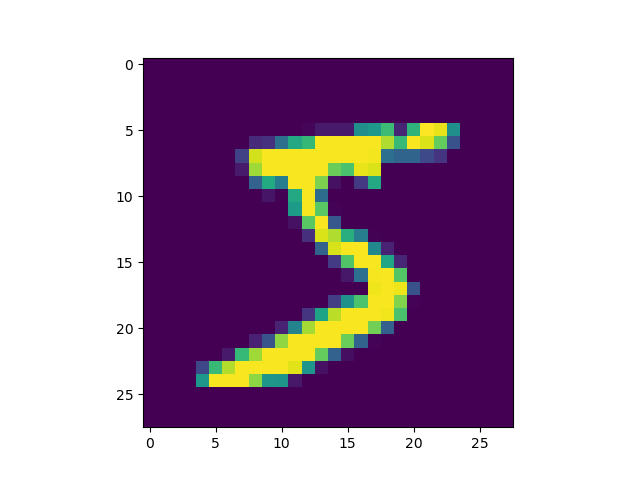

In [2]:
print("Image Size:", tuple(dataset[0][0].shape))
plt.imshow(dataset[0][0].moveaxis(0, -1))

In [3]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda") # GPU
else:
    device = torch.device("cpu") # CPU
    
print(f"Running PyTorch Using: {device}")

Running PyTorch Using: cuda


In [4]:
batch_size = 100

to_device = lambda a: a.to(device)

test_loader = torch.utils.data.DataLoader(test, batch_size, shuffle=True)
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)

In [283]:
# Functions for training a model...
def train_model(
    model, 
    train_data, 
    test_data, 
    optimizer, 
    error_func, 
    n_epochs,
    device,
    print_every=100,
    print_accuracy=True
):
    for epoch_i in range(1, n_epochs + 1):
        model.train()
        for i, (img, label) in enumerate(train_data, 1):
            # Zero gradients...
            model.zero_grad()
            # Run model...
            predicted = model.forward(img.to(device))
            
            # Compute loss, backpropigate, and optimize the weights...
            loss = error_func(predicted, label.to(device))
            loss.backward()
            optimizer.step()
            
            if((i % print_every == 0) or (i == len(train_data))):
                print(f"Epoch: {epoch_i}/{n_epochs}, Iter: {i}/{len(train_data)}, Loss: {loss:.04f}")
                
        # Run against the test set and train set at the end of each epoch to get accuracy...
        if(print_accuracy):
            model.eval()
            acc1 = get_accuracy(model, train_data)
            print(f"Epoch {epoch_i} Train Accuracy: {acc1 * 100:.02f}%")
            acc2 = get_accuracy(model, test_data)
            print(f"Epoch {epoch_i} Test Accuracy: {acc2 * 100:.02f}%\n")
    
    return model
        
        
def get_accuracy(model, data):
        run = 0
        correct = 0
        
        for img, label in data:
            run += len(img)
            result = model.forward(img.to(device)).cpu().detach().numpy()
            correct += np.sum(np.argmax(result, axis=1) == label.cpu().detach().numpy())
        
        return correct / run

### Model Without Dropout

In [535]:
class VanillaNN(nn.Module):
    def __init__(self, input_size: tuple, hidden_layer_sizes: list, class_count: int): 
        super().__init__()
        layers = [
            nn.Linear(np.prod(input_size), hidden_layer_sizes[0]),
            nn.LeakyReLU()
        ]
        
        for this_size, next_size in zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:]):
            layers.extend([
                nn.Linear(this_size, next_size),
                nn.LeakyReLU()
            ])
            
        layers.append(nn.Linear(hidden_layer_sizes[-1], class_count))
        
        self._linear_layers = nn.Sequential(*layers)
        self._softmax = nn.Softmax(-1)
        
    def linear_layer(self, index: int):
        return self._linear_layers[index * 2]
        
    def forward(self, x: torch.tensor, exec_depth: int = None) -> torch.tensor:
        if(exec_depth is None):
            return self._softmax(self._linear_layers(x.reshape(x.shape[0], -1)))
        else:
            # Return internal values exec_layers layers in...
            return self._linear_layers[:exec_depth * 2](x.reshape(x.shape[0], -1))

In [536]:
vnn = VanillaNN(dataset[0][0].shape, [40, 40, 40], 10).to(device)
print(vnn)

VanillaNN(
  (_linear_layers): Sequential(
    (0): Linear(in_features=784, out_features=40, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=40, out_features=40, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=40, out_features=10, bias=True)
  )
  (_softmax): Softmax(dim=-1)
)


In [537]:
n_epochs = 10
lr = 1e-4

# Set up everything...
optimizer = optim.Adam(vnn.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

In [538]:
vnn = train_model(vnn, train_loader, test_loader, optimizer, loss_func, n_epochs, device)

Epoch: 1/10, Iter: 100/480, Loss: 2.2896
Epoch: 1/10, Iter: 200/480, Loss: 2.1959
Epoch: 1/10, Iter: 300/480, Loss: 2.0451
Epoch: 1/10, Iter: 400/480, Loss: 1.8501
Epoch: 1/10, Iter: 480/480, Loss: 1.9037
Epoch 1 Train Accuracy: 64.15%
Epoch 1 Test Accuracy: 64.35%

Epoch: 2/10, Iter: 100/480, Loss: 1.8892
Epoch: 2/10, Iter: 200/480, Loss: 1.8945
Epoch: 2/10, Iter: 300/480, Loss: 1.7318
Epoch: 2/10, Iter: 400/480, Loss: 1.7957
Epoch: 2/10, Iter: 480/480, Loss: 1.7932
Epoch 2 Train Accuracy: 70.49%
Epoch 2 Test Accuracy: 71.00%

Epoch: 3/10, Iter: 100/480, Loss: 1.8239
Epoch: 3/10, Iter: 200/480, Loss: 1.8665
Epoch: 3/10, Iter: 300/480, Loss: 1.8064
Epoch: 3/10, Iter: 400/480, Loss: 1.7062
Epoch: 3/10, Iter: 480/480, Loss: 1.7626
Epoch 3 Train Accuracy: 72.78%
Epoch 3 Test Accuracy: 73.15%

Epoch: 4/10, Iter: 100/480, Loss: 1.7667
Epoch: 4/10, Iter: 200/480, Loss: 1.7869
Epoch: 4/10, Iter: 300/480, Loss: 1.7304
Epoch: 4/10, Iter: 400/480, Loss: 1.7232
Epoch: 4/10, Iter: 480/480, Loss: 1

In [539]:
print(f"Final Model Test Accuracy: {get_accuracy(vnn, test_loader) * 100:.02f}%")

Final Model Test Accuracy: 82.90%


### Model With Dropout

In [540]:
class DropoutNN(nn.Module):
    def __init__(
        self, 
        input_size: tuple, 
        hidden_layer_sizes: list, 
        dropout_values: list, 
        class_count: int
    ):
        super().__init__()
        layers = [
            nn.Dropout(dropout_values[0]),
            nn.Linear(np.prod(input_size), hidden_layer_sizes[0]),
            nn.LeakyReLU()
        ]
        
        for this_size, next_size, dv in zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:], dropout_values[1:]):
            layers.extend([
                nn.Dropout(dv),
                nn.Linear(this_size, next_size),
                nn.LeakyReLU()
            ])
            
        layers.extend([
            nn.Dropout(dropout_values[-1]),
            nn.Linear(hidden_layer_sizes[-1], class_count)
        ])
        
        self._linear_layers = nn.Sequential(*layers)
        self._softmax = nn.Softmax(-1)
        
    def linear_layer(self, index: int):
        return self._linear_layers[index * 3 + 1]
        
    def forward(self, x: torch.tensor, exec_depth: int = None) -> torch.tensor:
        if(exec_depth is None):
            return self._softmax(self._linear_layers(x.reshape(x.shape[0], -1)))
        else:
            # Return internal values exec_layers layers in...
            return self._linear_layers[:exec_depth * 3](x.reshape(x.shape[0], -1))

In [541]:
dnn = DropoutNN(dataset[0][0].shape, [40, 40, 40], [0.2, 0.5, 0.5, 0.5], 10).to(device)
print(dnn)

DropoutNN(
  (_linear_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=784, out_features=40, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=40, out_features=40, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=40, out_features=40, bias=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=40, out_features=10, bias=True)
  )
  (_softmax): Softmax(dim=-1)
)


In [542]:
n_epochs2 = 20
lr2 = 1e-4

# Set up everything...
optimizer2 = optim.Adam(dnn.parameters(), lr=lr2)
loss_func2 = nn.CrossEntropyLoss()

In [543]:
dnn = train_model(dnn, train_loader, test_loader, optimizer2, loss_func2, n_epochs2, device)

Epoch: 1/20, Iter: 100/480, Loss: 2.3007
Epoch: 1/20, Iter: 200/480, Loss: 2.2958
Epoch: 1/20, Iter: 300/480, Loss: 2.2845
Epoch: 1/20, Iter: 400/480, Loss: 2.2765
Epoch: 1/20, Iter: 480/480, Loss: 2.2062
Epoch 1 Train Accuracy: 33.37%
Epoch 1 Test Accuracy: 33.43%

Epoch: 2/20, Iter: 100/480, Loss: 2.2180
Epoch: 2/20, Iter: 200/480, Loss: 2.1601
Epoch: 2/20, Iter: 300/480, Loss: 2.1865
Epoch: 2/20, Iter: 400/480, Loss: 2.0848
Epoch: 2/20, Iter: 480/480, Loss: 2.1172
Epoch 2 Train Accuracy: 42.56%
Epoch 2 Test Accuracy: 42.66%

Epoch: 3/20, Iter: 100/480, Loss: 2.0251
Epoch: 3/20, Iter: 200/480, Loss: 2.0250
Epoch: 3/20, Iter: 300/480, Loss: 2.0250
Epoch: 3/20, Iter: 400/480, Loss: 2.1016
Epoch: 3/20, Iter: 480/480, Loss: 2.1151
Epoch 3 Train Accuracy: 61.11%
Epoch 3 Test Accuracy: 61.22%

Epoch: 4/20, Iter: 100/480, Loss: 2.0271
Epoch: 4/20, Iter: 200/480, Loss: 1.9832
Epoch: 4/20, Iter: 300/480, Loss: 1.9909
Epoch: 4/20, Iter: 400/480, Loss: 2.0361
Epoch: 4/20, Iter: 480/480, Loss: 2

In [544]:
dnn.eval()
print(f"Final Model Test Accuracy: {get_accuracy(dnn, test_loader) * 100:.02f}%")

Final Model Test Accuracy: 85.70%


### Visualizing Model Layers

In [545]:
def plot_first_hidden_layer(
    model: nn.Module, 
    title: str, 
    height: int, 
    width: int, 
    depth: int, 
    num_samples: int = 10
):
    # Get the weights...
    weight = model.linear_layer(0).weight
    # Detach them and reshape them into the image size...
    weight = weight.cpu().detach().numpy().reshape(-1, depth, height, width)
        
    fig, axs = plt.subplots(depth, num_samples, squeeze=False)
    fig.set_size_inches(3 * num_samples, 3 * depth)
    fig.suptitle(title)
    
    selected_filters = np.random.choice(len(weight), num_samples, replace=False)
    for i, sub_axs in zip(selected_filters, axs.T):
        img = weight[i]
        
        for j, ax in enumerate(sub_axs):
            ax.set_title(f"Cell {i}, Channel {j}")
            ax.imshow(img[j])
    
    fig.tight_layout()
    fig.show()

/tmp/ipykernel_31059/982768779.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


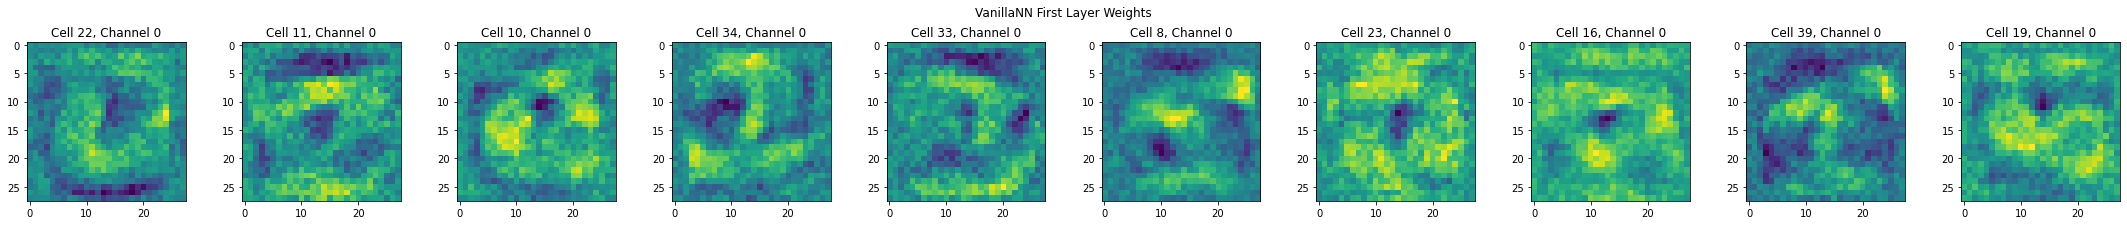

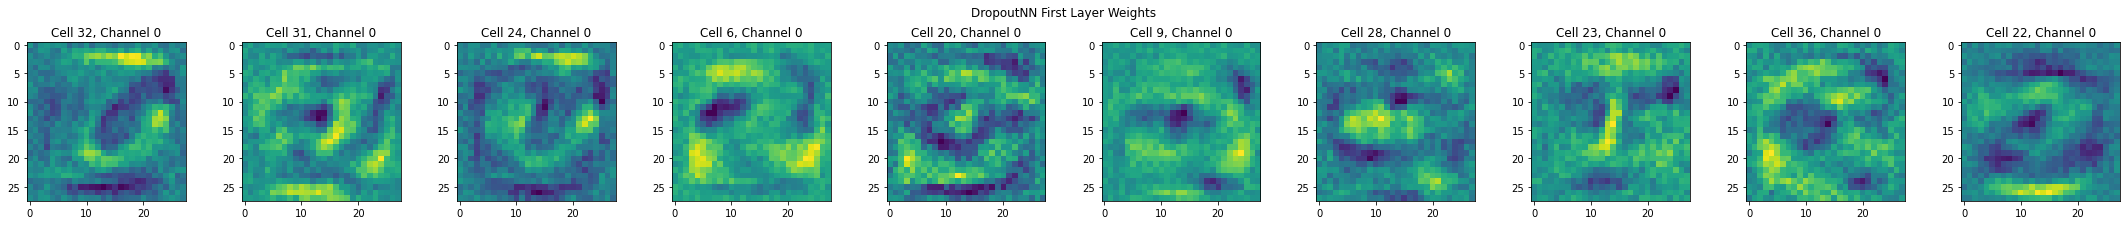

In [548]:
%matplotlib inline

d, h, w = dataset[0][0].shape
plot_first_hidden_layer(vnn, "VanillaNN First Layer Weights", h, w, d)
plot_first_hidden_layer(dnn, "DropoutNN First Layer Weights", h, w, d)

In [600]:
def generate_optimal_image(
    model: nn.Module,
    run_through_layers: int,
    nodes: int,
    width: int,
    height: int,
    depth: int,
    device,
    learning_rate: int = 5e-4,
    epochs: int = 7500,
    optimize_range: bool = False
) -> np.ndarray:
    # Put model in evaluation mode, we only want to optimize the image...
    model.eval()
    # Create a random image...
    img = torch.randn(1, depth, height, width, device=device, requires_grad=True)
    optimizer = optim.Adam([img], lr=learning_rate)
    loss_func = nn.MSELoss()
    
    print(f"Optimizing result after linear layer {model.linear_layer(run_through_layers - 1)}"
          f" for the following node indexes: {nodes}")
    
    for i in range(epochs):
        # Zero gradients...
        if img.grad is not None:
            img.grad.detach_()
            img.grad.zero_()
        model.zero_grad()
        # Run model...
        predicted = model.forward(img, run_through_layers)
        
        mask = np.zeros(predicted.shape[1], bool)
        mask[nodes] = 1
        
        node_score = torch.min(predicted[0, mask])
        not_node_score = torch.max(predicted[0, ~mask])
        
        # Compute loss, backpropigate, and optimize the weights...
        # Our loss: Maximize the range between nodes of interest and other nodes
        loss = -node_score if(not optimize_range) else -node_score + not_node_score
        
        loss.backward()
        optimizer.step()
        
        # All images are made up of channels that range from 0 to 1, so clamp values within that range...
        with torch.no_grad():
            img.clamp_(0, 1)

        if((i % 500 == 0) or (i == (epochs - 1))):
            print(f"Epoch: {i}/{epochs}, Loss: {loss:.02f}")
            
    return img

In [607]:
img = generate_optimal_image(vnn, 4, 0, h, w, d, device, optimize_range=True)

Optimizing result after linear layer Linear(in_features=40, out_features=10, bias=True) for the following node indexes: 0
Epoch: 0/7500, Loss: 3.18
Epoch: 500/7500, Loss: -10.20
Epoch: 1000/7500, Loss: -18.80
Epoch: 1500/7500, Loss: -25.02
Epoch: 2000/7500, Loss: -30.58
Epoch: 2500/7500, Loss: -34.76
Epoch: 3000/7500, Loss: -36.80
Epoch: 3500/7500, Loss: -37.79
Epoch: 4000/7500, Loss: -38.28
Epoch: 4500/7500, Loss: -38.53
Epoch: 5000/7500, Loss: -38.67
Epoch: 5500/7500, Loss: -38.75
Epoch: 6000/7500, Loss: -38.79
Epoch: 6500/7500, Loss: -38.82
Epoch: 7000/7500, Loss: -38.85
Epoch: 7499/7500, Loss: -38.86


In [608]:
def to_string(arr):
    return " ".join(f"{f: 8.02f}" for f in arr)

print("Node Index:    ", to_string(range(len(dnn.forward(img, 4)[0]))))
print("Score:         ", to_string(dnn.forward(img, 4)[0]))
print("Softmax Score: ", to_string(torch.softmax(dnn.forward(img, 4)[0], -1)))

Node Index:         0.00     1.00     2.00     3.00     4.00     5.00     6.00     7.00     8.00     9.00
Score:             32.63   -69.52     0.49    -0.23   -37.93    12.25   -20.93   -28.06    -6.41   -51.82
Softmax Score:      1.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00


/tmp/ipykernel_31059/2691923320.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


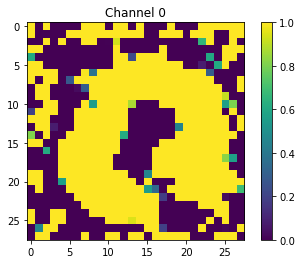

In [609]:
img2 = img.cpu().detach().numpy()
img2 = np.reshape(img2, (d, h, w))

fig, axs = plt.subplots(1, d, squeeze=False)

for i, ax in enumerate(axs[0]):
    ax.set_title(f"Channel {i}")
    m = ax.imshow(img2[i])
    
fig.colorbar(m)
fig.show()